In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.random_projection import SparseRandomProjection
import time
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
# Dataset 2 (Cover type)
dfname = "covertype"
df = pd.read_csv("../Classification/covtype.csv")
df = df.sample(frac=0.1, random_state=0, axis=0)

X_raw = df.drop('Cover_Type',1)
X_raw.to_csv("{}_raw_X.csv".format(dfname))

Y = df['Cover_Type']
Y.to_csv("{}_corresponding_Y.csv".format(dfname), header=False)

X = StandardScaler().fit_transform(X_raw)

# Plotting UDF

In [3]:
# plot top components
def plot_components(title, top_comp, components, ncol, nrow, image_h, image_w):
    plt.figure(figsize=(3. * ncol, 3.26 * nrow))
    plt.title(title, size=16)
    for i in range(top_comp):
        plt.subplot(nrow, ncol, i+1)
        plt.title("No.{} component".format(i+1))
        sns.heatmap(components[i, :].reshape(image_h, image_w), cmap='gray_r')
        plt.axis('off')
    
    plt.suptitle(title) 
    
# plot PCA variance explained
def plot_pca_variance(exp_var):
    exp_var = pd.Series(exp_var)
    exp_var_ratio = exp_var/sum(exp_var)
    exp_var_ratio_cumsum = exp_var_ratio.cumsum()

    top_dims = len(exp_var_ratio)
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.bar(range(0, top_dims), exp_var_ratio[0:top_dims], align='center', alpha=0.5)
    ax2.plot(range(0, top_dims), exp_var_ratio_cumsum[0:top_dims], 'r-')
    
    ax1.set_xlabel('number of components')
    ax1.set_ylabel('component-wise explained variance ratio')
    ax2.set_ylabel('cumulative explained variance ratio')
    plt.title("PCA Component-wise and Cumulative Explained Variance")
    

# plot ICA by component kurtosis
def plot_ica_kurtosis(kurt):
    top_dims = len(kurt)   
    plt.figure(figsize=(8, 5))
    plt.bar(range(0, top_dims), kurt, align='center', alpha=0.5)
    plt.xlabel('number of components')
    plt.ylabel('component-wise kurtosis')
    plt.title("ICA Component-wise Kurtosis")   

# Dimension Reduction

In [4]:
# allowing the maximum number of dimensions for PCA
#n_components = 300
n_components = 54

# List of the different dimension reduction estimators
estimators = [
    ('PCA', PCA(n_components=n_components, svd_solver='randomized', whiten=True)),
    ('Randomized Projection', SparseRandomProjection(n_components=n_components, random_state=0)),
    ('Factor Analysis', FactorAnalysis(n_components=n_components, max_iter=5)),
    ('ICA', FastICA(n_components=n_components, whiten=True, random_state=0))
]


Extracting the top 54 PCA...
done in 2.745s
Extracting the top 54 Randomized Projection...
done in 0.053s
Extracting the top 54 Factor Analysis...
done in 7.357s
Extracting the top 54 ICA...
done in 75.300s


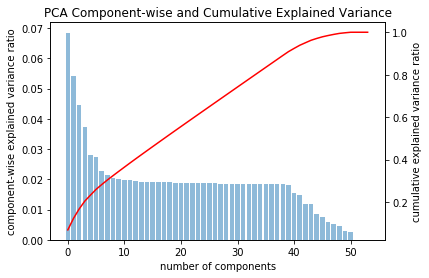

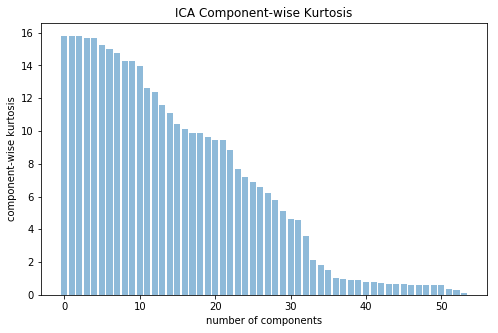

In [5]:
# Perform Dimension Reducton and Visualize top components

# original picture number of pixels in hight and width
image_h = 28
image_w = 28

# subplots settings
top_comp = 4
ncol = 4
nrow = top_comp//ncol + 1


for name, estimator in estimators:
    # Perform estimator
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    estimator.fit(X)
    X_trans = estimator.fit_transform(X)
    train_time = (time.time() - t0)
    components = estimator.components_
    if not isinstance(components, np.ndarray):
        components = components.toarray()
    print("done in %0.3fs" % train_time)
    
    # if ICA, sort components by kurtosis
    if name == 'ICA':
        # if ICA, sort components by kurtosis
        if not isinstance(components, pd.DataFrame):
            components = pd.DataFrame(components)
        kurt = pd.Series(components.kurt(axis=1).values)
        sorted_index = kurt.sort_values(ascending=False).index      
        components = components.iloc[sorted_index, :]
        
        # plot sorted top components and save sorted transformed X
        #plot_components("%s Top Components" % (name), top_comp, components.values, ncol, nrow, image_h, image_w)
        X_trans = pd.DataFrame(X_trans).iloc[:, sorted_index]
        fname = "%s_%s_transformed_X_%s_components_sorted_by_kurtosis.csv" % (dfname, name, n_components)
        X_trans.to_csv(fname, header=False)
        
        # plot kurtosis of the sorted components
        plot_ica_kurtosis(kurt[sorted_index])  
    
    else:
        # plot top components and save transformed X
        #plot_components("%s Top Components" % (name), top_comp, components, ncol, nrow, image_h, image_w)      
        fname = "%s_%s_transformed_X_%s_components.csv" % (dfname, name, n_components)
        pd.DataFrame(X_trans).to_csv(fname, header=False)
            
    
    # Visualize PCA variance explained
    if name == 'PCA':
        exp_var = estimator.explained_variance_
        plot_pca_variance(exp_var)  

plt.show()

# Reconstruction Error

In [6]:
#components_range = range(5, 100, 5)
recons_error = {}

for n in components_range:
    for name, estimator in estimators:
        if isinstance(estimator, (PCA, FastICA)):
            print("Reconstruction the top %d %s..." % (n, name))
            estimator.set_params(n_components=n)
            estimator.fit(X)
            X_trans = estimator.fit_transform(X)
            X_recon = pd.DataFrame(estimator.inverse_transform(X_trans))
            error = np.sqrt((X_recon - X).apply(np.square).mean()).mean()

            if name not in recons_error:
                recons_error[name] = []
            recons_error[name].append(error) 

Reconstruction the top 5 PCA...
Reconstruction the top 5 ICA...
Reconstruction the top 10 PCA...
Reconstruction the top 10 ICA...
Reconstruction the top 15 PCA...
Reconstruction the top 15 ICA...
Reconstruction the top 20 PCA...
Reconstruction the top 20 ICA...
Reconstruction the top 25 PCA...
Reconstruction the top 25 ICA...
Reconstruction the top 30 PCA...
Reconstruction the top 30 ICA...
Reconstruction the top 35 PCA...
Reconstruction the top 35 ICA...
Reconstruction the top 40 PCA...
Reconstruction the top 40 ICA...
Reconstruction the top 45 PCA...
Reconstruction the top 45 ICA...
Reconstruction the top 50 PCA...
Reconstruction the top 50 ICA...
Reconstruction the top 55 PCA...


ValueError: n_components=55 must be between 1 and min(n_samples, n_features)=54 with svd_solver='randomized'

In [ ]:
plt.subplots()
ica, = plt.plot(components_range, recons_error['ICA'])
pca, = plt.plot(components_range, recons_error['PCA'])
plt.xlabel("Number of components")
plt.title("Raw Data Reconstruction Error")
plt.legend([ica, pca], ['ICA', 'PCA'])
plt.show()